# Performance analysis of string building with Python

In [1]:
import random
import statistics
import string
from timeit import default_timer as timer

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

In [10]:
from IPython.display import HTML
from pathlib import Path

# load custom CSS for old-fashioned dataframe style
css_rules = Path('custom.css').read_text()
HTML('<style>' + css_rules + '</style>')

In [3]:
NUM_EXEC_LOOPS = 1000
MAX_STRING_SIZE = 1000
STRING_SIZE_STEP = 100
NANOSECONDS = 1e6

STR_EXPRESSIONS = {
    'f-string': "f'{s} {t}'",
    'concat': "s + ' ' + t",
    'join': "''.join((s, t))",
    'modulus': "'%s %s' % (s, t)",
    'format': "'{} {}'.format(s, t)",
    'template': "string.Template('$s $t').substitute(s=s, t=t)",
}

In [11]:
def build_random_string(size):
    ''' Return a string with <size> randomized chars taken from ASCII letters'''
    return ''.join([random.choice(string.ascii_letters) for _ in range(size)])

## Data generation

In [5]:
columns = ['str_size'] + list(STR_EXPRESSIONS.keys())
data = []
for size in range(0, MAX_STRING_SIZE + 1, STRING_SIZE_STEP):
    s = build_random_string(size)
    t = build_random_string(size)

    results = []
    for label, expr in STR_EXPRESSIONS.items():
        execution_times = []
        for _ in range(NUM_EXEC_LOOPS):
            start = timer()
            r = eval(expr)
            end = timer()
            execution_times.append(end - start)
        # compute mean to "smooth" some outliers
        mean_execution_time = statistics.mean(execution_times) * NANOSECONDS
        results.append(mean_execution_time)
    data.append([size] + results)

df = pd.DataFrame(data, columns=columns)
df = df.set_index('str_size')
df.head()

,f-string,concat,join,modulus,format,template
str_size,,,,,,
0,20.690537,11.012467,13.548735,13.571325,13.249390,23.295352
100,16.964042,9.051173,13.047302,11.379294,12.058025,23.236082
200,17.263881,9.245870,13.414464,11.811523,12.594804,23.607448
300,17.561004,9.257182,13.265409,11.562068,12.487739,23.150574
400,17.233927,10.829590,13.606352,11.781341,12.999152,23.462739


## "Smooth" data with cubic interpolation

In [7]:
new_index = np.arange(0, df.index.max() + 1)
df_cubic = pd.DataFrame(index=new_index)
for column in df.columns:
    f = interp1d(df.index, df[column], kind='cubic')
    df_cubic[column] = f(df_cubic.index)

## Plot data

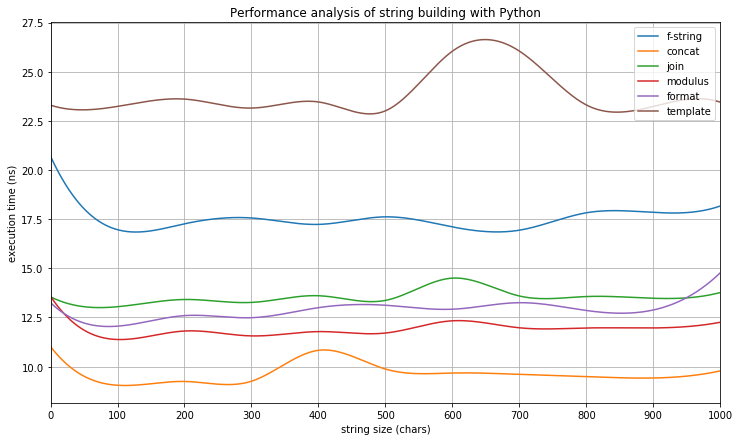

In [12]:
ax = df_cubic.plot(
    figsize=(12, 7),
    grid=True,
    xticks=df.index,
    title='Performance analysis of string building with Python'
)
ax.set_xlabel('string size (chars)')
ax.set_ylabel('execution time (ns)');